# 08.1 Structural Models - Merton & Black–Cox
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:
- Introduce structural credit-risk modelling via firm-value dynamics
- Derive Merton's (1974) model: equity = call option on assets, debt = risk-free bond − put
- Compute credit spread, survival probability, default probability
- Introduce Black–Cox (first-passage) default with a barrier
- Show the link with barrier options
- Provide minimal, clean Python code to compute Merton prices and visualize default probabilities

**This notebook**: 

Turns the structural idea “default = assets fall below liabilities” into explicit pricing formulas.
We will derive the Merton decomposition, compute default probabilities from GBM, and implement Black–Cox survival with the reflected Brownian motion formula.
This is the bridge between equity derivatives and credit-risk modelling.

# 1. Firm-value dynamics under the risk-neutral measure

The firm value follows a GBM under $\mathbb{Q}$:

$$
dV_t = V_t\left((r - k)\,dt + \sigma\,dW_t\right), \quad V_0 > 0
$$

- $r$ = risk-free rate
- $k$ = payout rate (dividends, coupons, leakage)
- $\sigma$ = asset volatility

**Debt**: zero-coupon bond with face value $L$ at maturity $T$.

**Default**: occurs only at $T$ in the Merton model.

# 2. Merton (1974) - Default only at maturity

Default if:

$$V_T < L$$

Debt payoff: $V_T \wedge L = L - (L - V_T)^+$

So the value of debt is:

$$D_t = E[e^{-r(T-t)}(V_T \wedge L) \mid \mathcal{F}_t] = Le^{-r(T-t)} - P_{BS}(V_t; K=L)$$

where $P_{BS}$ is the Black–Scholes put price.

Equity: $E_T = (V_T - L)^+$

So equity = call on the firm value:

$$E_t = C_{BS}(V_t; K=L)$$

Merton cleanly decomposes the firm capital structure:

- **Equity** = call
- **Debt** = risk-free bond − put
- **Credit spread** = put premium


# 3. Default probability in Merton

GBM explicit solution:

$$\ln V_T \sim N\left(\ln V_t + \left(r - k - \frac{1}{2}\sigma^2\right)(T-t), \sigma^2(T-t)\right)$$

Thus:

$$P(V_T < L) = \Phi\left(\frac{\ln(L/V_t) - \left(r - k - \frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}}\right)$$

We will implement this numerically.

# 4. Black–Cox (1976): default by first passage

Default can occur before maturity:

$$\tau = \inf\{t \geq 0 : V_t \leq H(t)\},$$

where $H(t)$ is a barrier. A common parametrisation:

$$H(t) = \tilde{L}\,e^{-\gamma(T-t)}, \quad H(T) = L.$$

**Interpretation**

If assets hit a covenant threshold, bankruptcy is triggered.

This introduces surprise default, unlike Merton where default can only be forecast at maturity.

**Debt pricing**

Reduced to barrier option valuation:

- Down-and-out for survival
- Down-and-in for default component

Closed-form formulas exist for constant barriers.


# 5. Survival probability in Black–Cox

If barrier is flat $H$, then:

$$P(\tau>T)=\Phi(\eta_1)-\left(\frac{H}{V_t}\right)^{2\beta}\Phi(\eta_2),$$

where

$$\beta=\frac{2(r-k)}{\sigma^2}-1,$$

$$\eta_{1,2}=\frac{\ln(V_t/H)\pm(r-k-\frac{1}{2}\sigma^2)(T-t)}{\sigma\sqrt{T-t}}.$$

(This is the reflection principle for GBM.)

This will also be implemented numerically.


# 6. Numerical Implementation 

In [42]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Baseline parameters for examples
L = 100.0   # Face value / default barrier in Merton
H = 70.0    # Safety covenant / barrier level in Black–Cox (H < L)
r = 0.02    # Risk-free rate
k = 0.00    # Payout rate on assets (dividend)
T_short = 1.0   # 1-year horizon
T_long  = 5.0   # 5-year horizon (for comparison)


## 6.1 Merton Model – Default Probability and Debt Price

In [43]:
def merton_default_prob(V0, L, r, k, sigma, T):
    """
    Default probability P(V_T < L) in the Merton model,
    where log V_T is Gaussian under Q.
    """
    mu = np.log(V0) + (r - k - 0.5 * sigma**2) * T
    sd = sigma * np.sqrt(T)
    z = (np.log(L) - mu) / sd
    return norm.cdf(z)


def merton_debt_price(V0, L, r, k, sigma, T):
    """
    Value of risky debt in Merton:
    Debt = risk-free bond - put on the firm value.
    """
    d1 = (np.log(V0 / L) + (r - k + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put = L * np.exp(-r * T) * norm.cdf(-d2) - V0 * np.exp(-k * T) * norm.cdf(-d1)
    return L * np.exp(-r * T) - put

## 6.2 Black–Cox Model – Survival and Default Probability

In [ ]:
def black_cox_survival(V0, H, r, k, sigma, T):
    """
    Survival probability P(τ > T) in the Black–Cox model
    (first-passage of a GBM to a lower barrier H).

    We work with X_t = log(V_t / H), which follows a Brownian motion with drift.
    """
    # if the firm already starts below the barrier -> instant default
    if V0 <= H:
        return 0.0

    mu = r - k - 0.5 * sigma**2          # drift of log V_t under Q
    x0 = np.log(V0 / H)
    sd = sigma * np.sqrt(T)

    eta1 = (x0 + mu * T) / sd
    eta2 = (-x0 + mu * T) / sd
    term = np.exp(-2.0 * mu * x0 / sigma**2)

    surv = norm.cdf(eta1) - term * norm.cdf(eta2)

    # Numerical safety
    return float(np.clip(surv, 0.0, 1.0))


def black_cox_default_prob(V0, H, r, k, sigma, T):
    """
    Default probability in Black–Cox: 1 - survival.
    """
    return 1.0 - black_cox_survival(V0, H, r, k, sigma, T)

# 7. One-Dimensional Comparisons – Merton vs Black–Cox
## 7.1 Default probability as a function of V₀ (σ fixed)

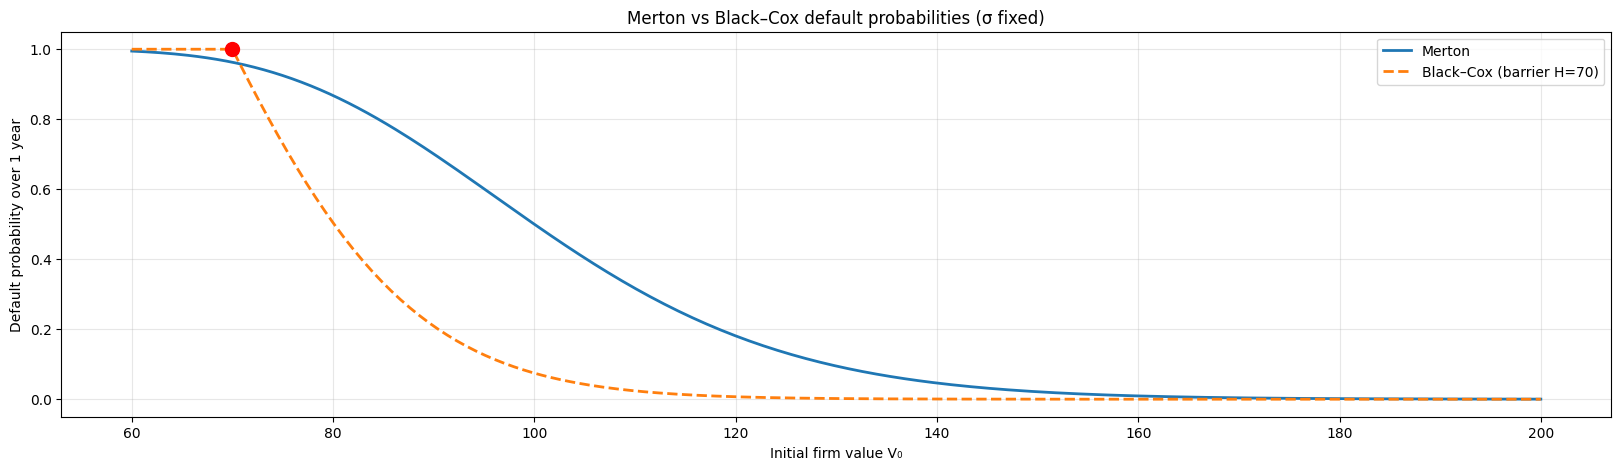

In [52]:
sigma_fixed = 0.20
T = T_short

V_vals = np.linspace(60, 200, 300)

p_merton = [merton_default_prob(V, L, r, k, sigma_fixed, T) for V in V_vals]
p_bc     = [black_cox_default_prob(V, H, r, k, sigma_fixed, T) for V in V_vals]

plt.figure(figsize=(20, 5))
plt.plot(V_vals, p_merton, label="Merton", linewidth=2)
plt.plot(V_vals, p_bc, "--", label=f"Black–Cox (barrier H={H:.0f})", linewidth=2)

# Add red dot at V₀ = 70 on the Black-Cox curve
p_bc_at_70 = black_cox_default_prob(70.0, H, r, k, sigma_fixed, T)
plt.scatter([70.0], [p_bc_at_70], color='red', s=100, zorder=5)

plt.xlabel("Initial firm value V₀")
plt.ylabel("Default probability over 1 year")
plt.title("Merton vs Black–Cox default probabilities (σ fixed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

For this choice of parameters (H = 70, L = 100), the Merton model appears more conservative: default occurs whenever the terminal firm value satisfies $V_T < 100$, while in the Black–Cox model default only happens if the process hits the lower barrier $H = 70$ before maturity.

Close to the barrier, Black–Cox gives almost certain default — the firm starts near $H$, so any downward fluctuation can trigger insolvency.
However, as soon as the firm value moves away from the barrier, the behaviour changes completely:
the probability of ever hitting 70 within one year drops extremely fast, much faster than the probability of ending below 100 at maturity.

This is exactly the structural difference between the two models:

**Merton default is purely terminal**: it only depends on $V_T$. Even if the firm spends most of the year above 100, a last-minute drop can trigger default.

**Black–Cox default is path-dependent**: the firm must hit the barrier during the year. If it starts sufficiently above 70 and volatility is moderate, the probability of crossing the barrier before maturity becomes very small.

The decline of the Black–Cox default curve as $V_0$ increases is not a flaw:
it is the expected behaviour of a first-passage model on a finite horizon.


## 7.2 Default probability as a function of σ (V₀ fixed)

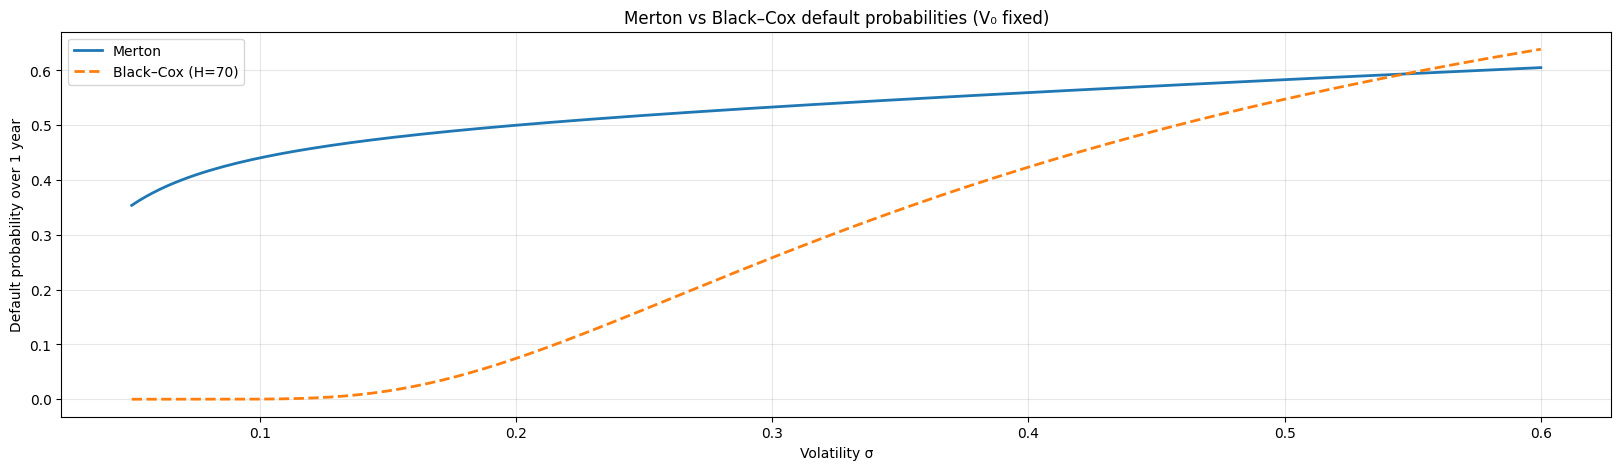

In [ ]:
V_fixed = 100.0
T = T_short

sigma_vals = np.linspace(0.05, 0.6, 200)

p_merton_sigma = [merton_default_prob(V_fixed, L, r, k, s, T) for s in sigma_vals]
p_bc_sigma     = [black_cox_default_prob(V_fixed, H, r, k, s, T) for s in sigma_vals]

plt.figure(figsize=(20, 5))
plt.plot(sigma_vals, p_merton_sigma, label="Merton", linewidth=2)
plt.plot(sigma_vals, p_bc_sigma, "--", label=f"Black–Cox (H={H:.0f})", linewidth=2)

plt.xlabel("Volatility σ")
plt.ylabel("Default probability over 1 year")
plt.title("Merton vs Black–Cox default probabilities (V₀ fixed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

For a fixed initial firm value $V_0$, the two models react very differently to changes in volatility.

In **Merton**, default occurs only if the terminal firm value satisfies $V_T$ < $100$.  
Since increasing σ widens the distribution of $V_T$, the probability of ending below the threshold rises smoothly and monotonically.  
The curve is concave and moderate: even with high volatility, the firm still retains a positive drift, so terminal default does not explode.

In **Black–Cox**, default occurs only if the process hits the barrier $H$ = $70$ at any time before maturity.  
For small volatilities, the probability of such an excursion is extremely low: the path remains close to its deterministic drift and rarely moves downward enough to touch the barrier.

However, as σ increases, the picture changes rapidly.  
Higher volatility creates large fluctuations, making downward excursions far more likely.  
The probability of ever hitting the barrier grows much faster than the probability of ending below the terminal threshold.

Beyond σ ≈ 0.55, the Black–Cox default probability becomes higher than in the Merton model : a signature feature of first-passage models: path-dependence amplifies the impact of volatility.

# 8. Two-Dimensional Visualisations – Default Probability Heatmaps

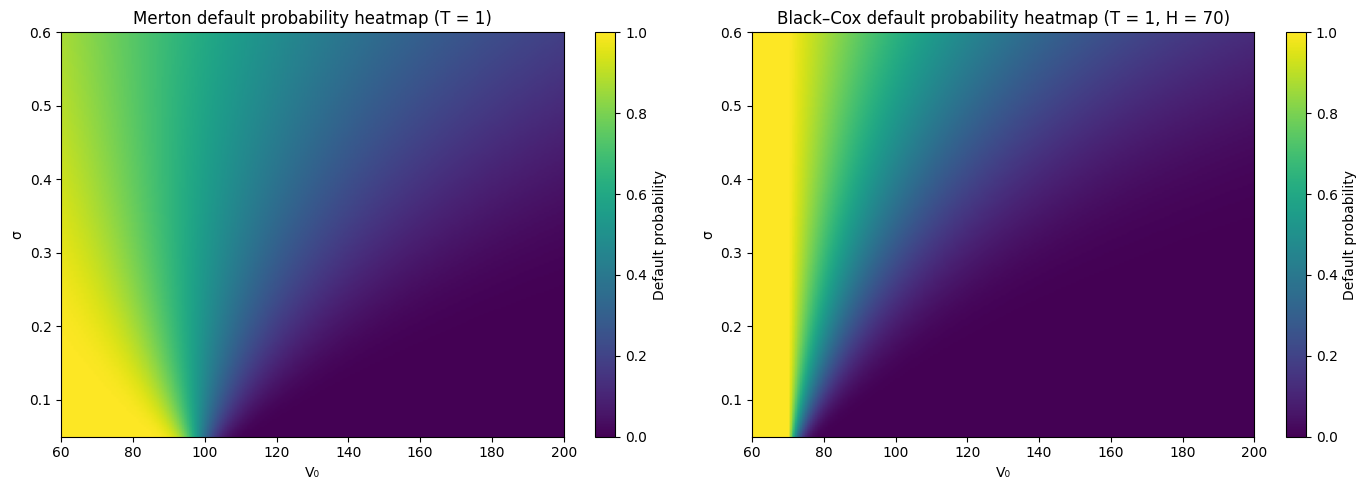

In [53]:
V_grid = np.linspace(60, 200, 200)
sigma_grid = np.linspace(0.05, 0.6, 200)

Z_merton = np.zeros((len(sigma_grid), len(V_grid)))

T = T_short

for i, s in enumerate(sigma_grid):
    for j, V in enumerate(V_grid):
        Z_merton[i, j] = merton_default_prob(V, L, r, k, s, T)

Z_bc = np.zeros((len(sigma_grid), len(V_grid)))

for i, s in enumerate(sigma_grid):
    for j, V in enumerate(V_grid):
        Z_bc[i, j] = black_cox_default_prob(V, H, r, k, s, T)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im1 = axes[0].imshow(
    Z_merton,
    extent=[V_grid[0], V_grid[-1], sigma_grid[0], sigma_grid[-1]],
    origin="lower",
    aspect="auto",
    cmap="viridis"
)
fig.colorbar(im1, ax=axes[0], label="Default probability")
axes[0].set_xlabel("V₀")
axes[0].set_ylabel("σ")
axes[0].set_title("Merton default probability heatmap (T = 1)")

im2 = axes[1].imshow(
    Z_bc,
    extent=[V_grid[0], V_grid[-1], sigma_grid[0], sigma_grid[-1]],
    origin="lower",
    aspect="auto",
    cmap="viridis"
)
fig.colorbar(im2, ax=axes[1], label="Default probability")
axes[1].set_xlabel("V₀")
axes[1].set_ylabel("σ")
axes[1].set_title(f"Black–Cox default probability heatmap (T = 1, H = {H:.0f})")

plt.tight_layout()
plt.show()

The left panel (Merton) shows a smooth and intuitive pattern: default is high when the initial firm value $V_0$ is low or when volatility is high, because default only depends on ending below the terminal threshold $L = 100$. As $V_0$ increases or σ decreases, the probability of finishing below the threshold declines gradually.

The right panel (Black–Cox) exhibits a very different geometry because default occurs when the process hits the barrier $H = 70$ at any time before maturity. Default is nearly certain when $V_0$ starts close to the barrier, but as soon as the firm value moves away from $H$, the probability of touching it within one year drops sharply. Higher volatility widens the range of possible excursions, creating a rising band of default risk for larger σ.